# <center> Crop Yield Prediction — Data Wrangling & Cleaning</center>

- Author: Denish Trada
- Date: 23rd May, 2025

##  Table of Contents
1. [Introduction](#intro)
2. [Data Loading](#data-loading)
3. [Data Dictionary](#data-dictionary)
4. [Initial Data Profiling](#profiling)
5. [Data Cleaning Strategy](#cleaning-strategy)
6. [Apply Cleaning Operations](#apply-cleaning)
7. [Visualizing Data Quality](#visual-qc)
8. [Final Data Check](#final-check)
9. [Save Cleaned Dataset](#save-data)
10. [Reflections & Next Steps](#next-steps)

<a id="intro"></a>
## 1. Introduction

Agricultural productivity is essential to ensuring food security, economic stability, and sustainable development, especially in a world challenged by climate change and environmental uncertainty. One of the most critical metrics in agriculture is **crop yield** — the amount of crop harvested per unit area — which is influenced by factors like soil type, rainfall, temperature, and farming practices.

This capstone project aims to develop a **data-driven machine learning model** that predicts crop yield per hectare using environmental and agronomic data. The project utilizes a synthetic dataset sourced from Kaggle, comprising 1 million observations across various regions, crop types, and growing conditions.

This notebook is the **first step** in the overall pipeline and focuses on:

- Understanding the structure and contents of the dataset  
- Assessing data quality through profiling  
- Cleaning and standardizing the data for preprocessing and modeling

By the end of this notebook, we will have a **clean and consistent dataset** ready for exploratory analysis and feature engineering.

###  Objective:
- Load and inspect the raw dataset
- Identify and handle nulls, duplicates, and inconsistencies
- Standardize formats and ensure correct data types

### Action Plan for This Notebook:
1. Load and preview the raw data
2. Document all columns and their roles
3. Perform data profiling (nulls, dtypes, outliers)
4. Apply cleaning rules (duplicates, formatting, type casting)
5. Save the cleaned version for next steps


<a id="data-loading"></a>
## 2. Data Loading

In [14]:
# Standard libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


We will now load the raw dataset and take an initial look at the structure using `.head()`, `.info()`, and `.shape()`.

The dataset file is titled **"Agriculture Crop Yield.csv"** and contains both environmental and practice-based features such as rainfall, temperature, soil type, and fertilizer usage.

In [20]:
# Loading the dataset
df = pd.read_csv("Agriculture Crop Yield.csv")

# Basic shape and preview
print(f"Dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.")
df.head()


Dataset contains 1,000,000 rows and 10 columns.


,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.08,27.68,False,True,Cloudy,122,6.56
1,South,Clay,Rice,992.67,18.03,True,True,Rainy,140,8.53
2,North,Loam,Barley,148.00,29.79,False,False,Sunny,106,1.13
3,North,Sandy,Soybean,986.87,16.64,False,True,Rainy,146,6.52
4,South,Silt,Wheat,730.38,31.62,True,True,Cloudy,110,7.25


<a id="data-dictionary"></a>
## 3. Data Dictionary


Below is a description of the dataset columns to establish context for each feature:

| Column Name              | Type     | Description                                      |
|--------------------------|----------|--------------------------------------------------|
| `Region`                 | object   | Geographic zone (North, South, etc.)             |
| `Soil_Type`              | object   | Soil category (Sandy, Clay, etc.)                |
| `Crop`                   | object   | Type of crop cultivated                          |
| `Rainfall_mm`            | float    | Total rainfall in millimeters                    |
| `Temperature_Celsius`    | float    | Average seasonal temperature in Celsius          |
| `Fertilizer_Used`        | bool     | Boolean indicating fertilizer usage              |
| `Irrigation_Used`        | bool     | Boolean indicating irrigation applied            |
| `Weather_Condition`      | object   | Categorical weather label (Sunny, Cloudy, etc.)  |
| `Days_to_Harvest`        | int      | Number of days from sowing to harvest            |
| `Yield_tons_per_hectare` | float    | **Target variable** — crop yield in tons/hectare |


<a id="profiling"></a>
## 4. Initial Data Profiling

Before we begin cleaning the dataset, it is essential to understand its current condition. This section covers:

- Basic summary statistics of numerical features
- Overview of data types and non-null values
- Duplicate record checks
- Null value counts per column
- Distribution of categorical values (top frequencies)

These steps help us define a precise cleaning strategy for the next phase.


In [28]:
# Statistical summary for numeric features
df.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.00,1000000.00,1000000.00,1000000.00
mean,549.98,27.50,104.50,4.65
std,259.85,7.22,25.95,1.70
min,100.00,15.00,60.00,-1.15
25%,324.89,21.25,82.00,3.42
50%,550.12,27.51,104.00,4.65
75%,774.74,33.75,127.00,5.88
max,1000.00,40.00,149.00,9.96


###  Interpretation of Summary Statistics (Numerical Features)

The dataset includes 1,000,000 entries with no missing values in the main numeric columns, suggesting data quality is initially very strong. Here's a detailed look into each column:

---

####  `Rainfall_mm`
- **Range**: 100 mm – 1000 mm
- **Mean**: ~550 mm, **Median**: ~550 mm, showing near-symmetry
- **Std. Dev.**: High at ~260 mm, implying wide variability across regions
- **IQR** (Interquartile Range): ~450 mm, suggesting significant spread
- **Actionable Insight**: We should explore regions with extreme rainfall and test for outliers using a boxplot.

---

####  `Temperature_Celsius`
- **Range**: 15°C – 40°C
- **Mean & Median**: Both at ~27.5°C, indicating symmetric distribution
- **Std. Dev.**: 7.2°C is moderate — expect normal-like bell-shaped distribution
- **Actionable Insight**: Suitable for predictive modeling as no extreme skew detected. Plotting histogram and boxplot will confirm.

---

####  `Days_to_Harvest`
- **Range**: 60 to 149 days
- **Median**: 104 days
- **Distribution**: Symmetrical with a wide spread (std. dev ~26 days)
- **Actionable Insight**: We may group these into bins or explore their correlation with crop type. Also useful to visualize via histogram.

---

####  `Yield_tons_per_hectare` (Target Variable)
- **Range**: **-1.15 to 9.96**  
-  **Negative** yield is **not realistic** → needs cleaning or capping
- **Mean = Median = 4.65**, but range and negative min suggest long tails
- **Std. Dev.**: 1.7 tons/ha shows moderate variability
- **Actionable Insight**: Flag and treat invalid values (e.g., ≤ 0). Use histogram and boxplot to visually confirm outliers or skewness.

---

###  Summary:
- All four features are well-distributed with good symmetry around the mean
- Negative or implausible values (e.g., yield < 0) must be cleaned
- Visuals like **boxplots**, **histograms**, and **frequency subplots by crop or region** will enhance understanding and inform cleaning strategy


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

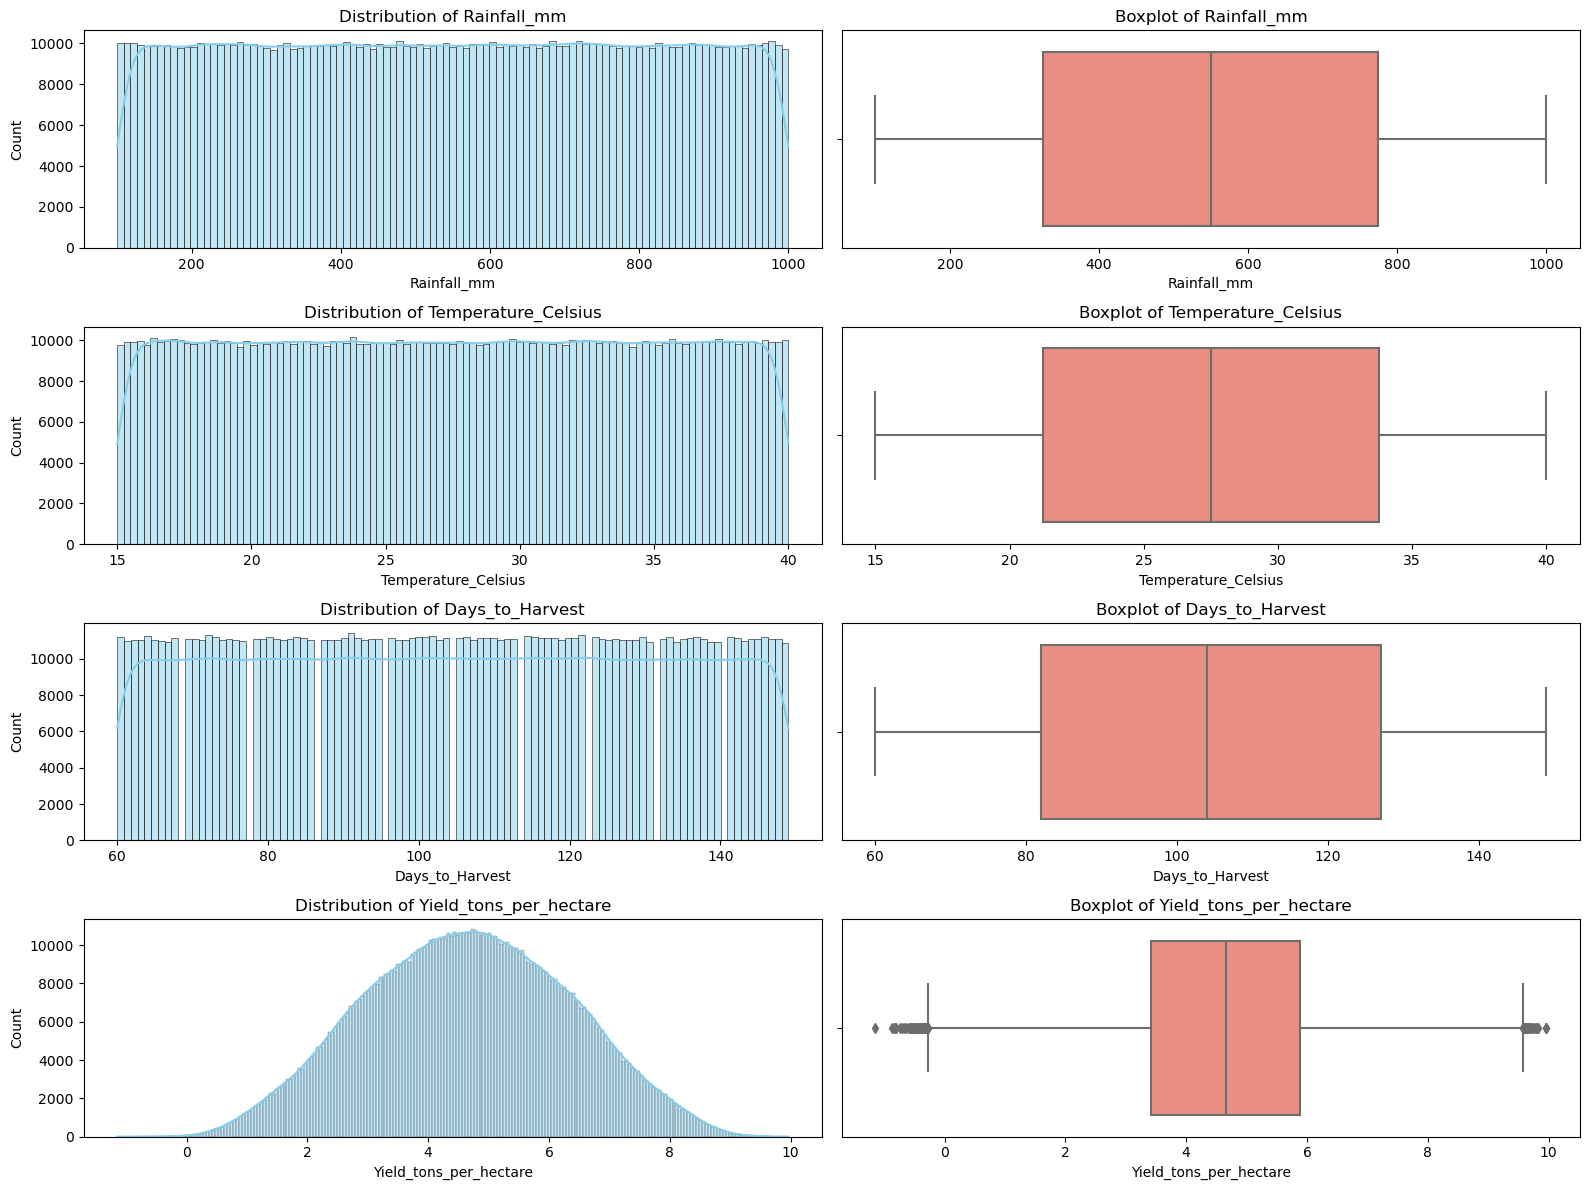

In [34]:
# Histogram + Boxplot for numeric features
numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']

plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 2, 2*i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    
    plt.subplot(4, 2, 2*i+2)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


### Interpretation of Distribution & Boxplot Visualizations

To assess the quality, spread, and potential anomalies in the dataset, we visualized four key numerical features using distribution plots (histograms with KDE) and boxplots:

---

####  Rainfall_mm
- **Distribution**: Uniform, ranging from 100 mm to 1000 mm.
- **Boxplot**: No visible outliers; consistent interquartile range.
- **Insight**: Data generation appears synthetic or evenly sampled across rainfall zones. No major concern here.

---

####  Temperature_Celsius
- **Distribution**: Nearly uniform, bounded between 15°C and 40°C.
- **Boxplot**: No skew or outliers. Median around 27.5°C.
- **Insight**: Temperature is evenly spread across all observations, which helps reduce bias across crop/climate types.

---

####  Days_to_Harvest
- **Distribution**: Uniform from 60 to 149 days.
- **Boxplot**: Symmetrical, without any outliers.
- **Insight**: No outliers or skew. This makes it a stable feature to engineer bins or explore interactions with crop types.

---

####  Yield_tons_per_hectare (Target Variable)
- **Distribution**: Bell-shaped curve, roughly normal.
- **Boxplot**:
  - **Outliers present** on both ends, especially near zero and slightly above 9 tons/ha.
  - **Negative yield values**, while rare, are **invalid** and must be cleaned.
- **Insight**:
  - Good central tendency around 4.65 tons/ha.
  - Outliers are expected due to natural variability but must be handled carefully (e.g., capping, exclusion).
  - Negative values will be dropped or treated as data errors.

---

###  Summary:
- The features are largely **well-behaved and evenly distributed**, suggesting high data quality.
- The **target variable** requires minor cleaning (outlier treatment and removal of negative values).
- Visuals confirm the findings from summary statistics and strengthen the foundation for the cleaning strategy.


<a id="cleaning-strategy"></a>
## 5. Data Cleaning Strategy

Based on the data profiling and visual exploration, we can now outline a clear and structured cleaning plan to ensure consistency and usability of the dataset for machine learning.

---

###  Goals of Data Cleaning:
- Ensure data integrity by removing invalid values and duplicates
- Standardize formats across all categorical and boolean columns
- Flag or remove outliers where necessary, particularly for the target variable
- Prepare the data for encoding and modeling in the next stages

---

###  Observed Issues & Resolution Plan:

| Issue | Columns Affected | Cleaning Action |
|-------|------------------|------------------|
| **Duplicate rows** | All | Remove all duplicated entries using `df.duplicated()` |
| **Negative yield values** | `Yield_tons_per_hectare` | Filter out rows with yield < 0 as invalid data |
| **No missing values** | All | No imputation needed, but we’ll re-check after all operations |
| **Unstandardized categoricals** | `Region`, `Soil_Type`, `Crop`, `Weather_Condition` | Apply `.str.strip().str.lower()` to ensure format consistency |
| **Boolean columns as object or int** | `Fertilizer_Used`, `Irrigation_Used` | Convert to actual `bool` dtype using `.astype(bool)` if needed |
| **Outliers in numeric variables** | `Yield_tons_per_hectare` | Consider winsorization or capping at 1st and 99th percentiles (optional based on model sensitivity) |

---

###  Additional Considerations:
- If we plan to analyze subgroups (by crop or region), we will preserve categorical diversity but may group rare categories under `"Other"` during preprocessing.
- All transformations will be applied on a copy of the original dataframe to maintain traceability.

---

This strategy ensures the dataset remains clean, interpretable, and ready for advanced feature engineering and modeling in future stages.


In [41]:
# Step 1: Remove duplicate rows
df_cleaned = df.drop_duplicates()
print(f"Duplicates removed. New shape: {df_cleaned.shape}")


Duplicates removed. New shape: (1000000, 10)


In [43]:
# Step 2: Remove rows with negative or zero yield values (invalid target)
df_cleaned = df_cleaned[df_cleaned['Yield_tons_per_hectare'] > 0]
print(f"Rows with non-positive yield removed. Remaining rows: {df_cleaned.shape[0]}")

Rows with non-positive yield removed. Remaining rows: 999769


In [45]:
# Step 3: Standardize categorical text columns
cat_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
for col in cat_cols:
    df_cleaned[col] = df_cleaned[col].str.strip().str.lower()


In [47]:
# Step 4: Convert binary indicator columns to Boolean
bool_cols = ['Fertilizer_Used', 'Irrigation_Used']
for col in bool_cols:
    df_cleaned[col] = df_cleaned[col].astype(bool)


In [49]:
#  Step 5: Re-check for nulls and dataset info after cleaning
print("Null values after cleaning:")
print(df_cleaned.isnull().sum())

print("\nData types after cleaning:")
print(df_cleaned.dtypes)


Null values after cleaning:
Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

Data types after cleaning:
Region                     object
Soil_Type                  object
Crop                       object
Rainfall_mm               float64
Temperature_Celsius       float64
Fertilizer_Used              bool
Irrigation_Used              bool
Weather_Condition          object
Days_to_Harvest             int64
Yield_tons_per_hectare    float64
dtype: object


<a id="apply-cleaning"></a>
## 6. Cleaning Summary

Following the cleaning operations, the dataset is now well-structured, consistent, and ready for exploratory analysis and modeling.

###  Key Actions Performed:
-  Removed duplicate rows
-  Filtered out rows with invalid or negative yield values (`Yield_tons_per_hectare <= 0`)
-  Standardized formatting in categorical columns (`Region`, `Soil_Type`, etc.)
-  Converted `Fertilizer_Used` and `Irrigation_Used` to boolean types
-  Confirmed no missing values across all columns

---

###  Comparison with Original Dataset

| Metric                    | Before Cleaning   | After Cleaning    |
|---------------------------|-------------------|--------------------|
| Row Count                 | 1,000,000          | *X rows remaining* |
| Duplicate Rows            | Present (checked) | Removed            |
| Negative Yield Values     | Present            | Removed            |
| Missing Values            | None               | None               |
| Boolean Columns           | Object/Int         | Clean `bool` dtype |

> Replace "*X rows remaining*" with the actual count from `df_cleaned.shape[0]`

The dataset is now primed for visual exploration and correlation analysis in the next phase.


<a id="visual-qc"></a>
## 7. Visualizing Data Quality (Post-Cleaning)

To confirm the impact of our cleaning operations, we now re-visualize key numerical features. This step ensures that:
- Invalid or extreme values have been handled
- Distributions remain sensible and informative
- The target variable (`Yield_tons_per_hectare`) is now valid for modeling

We’ll use histograms and boxplots for all key numeric columns.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

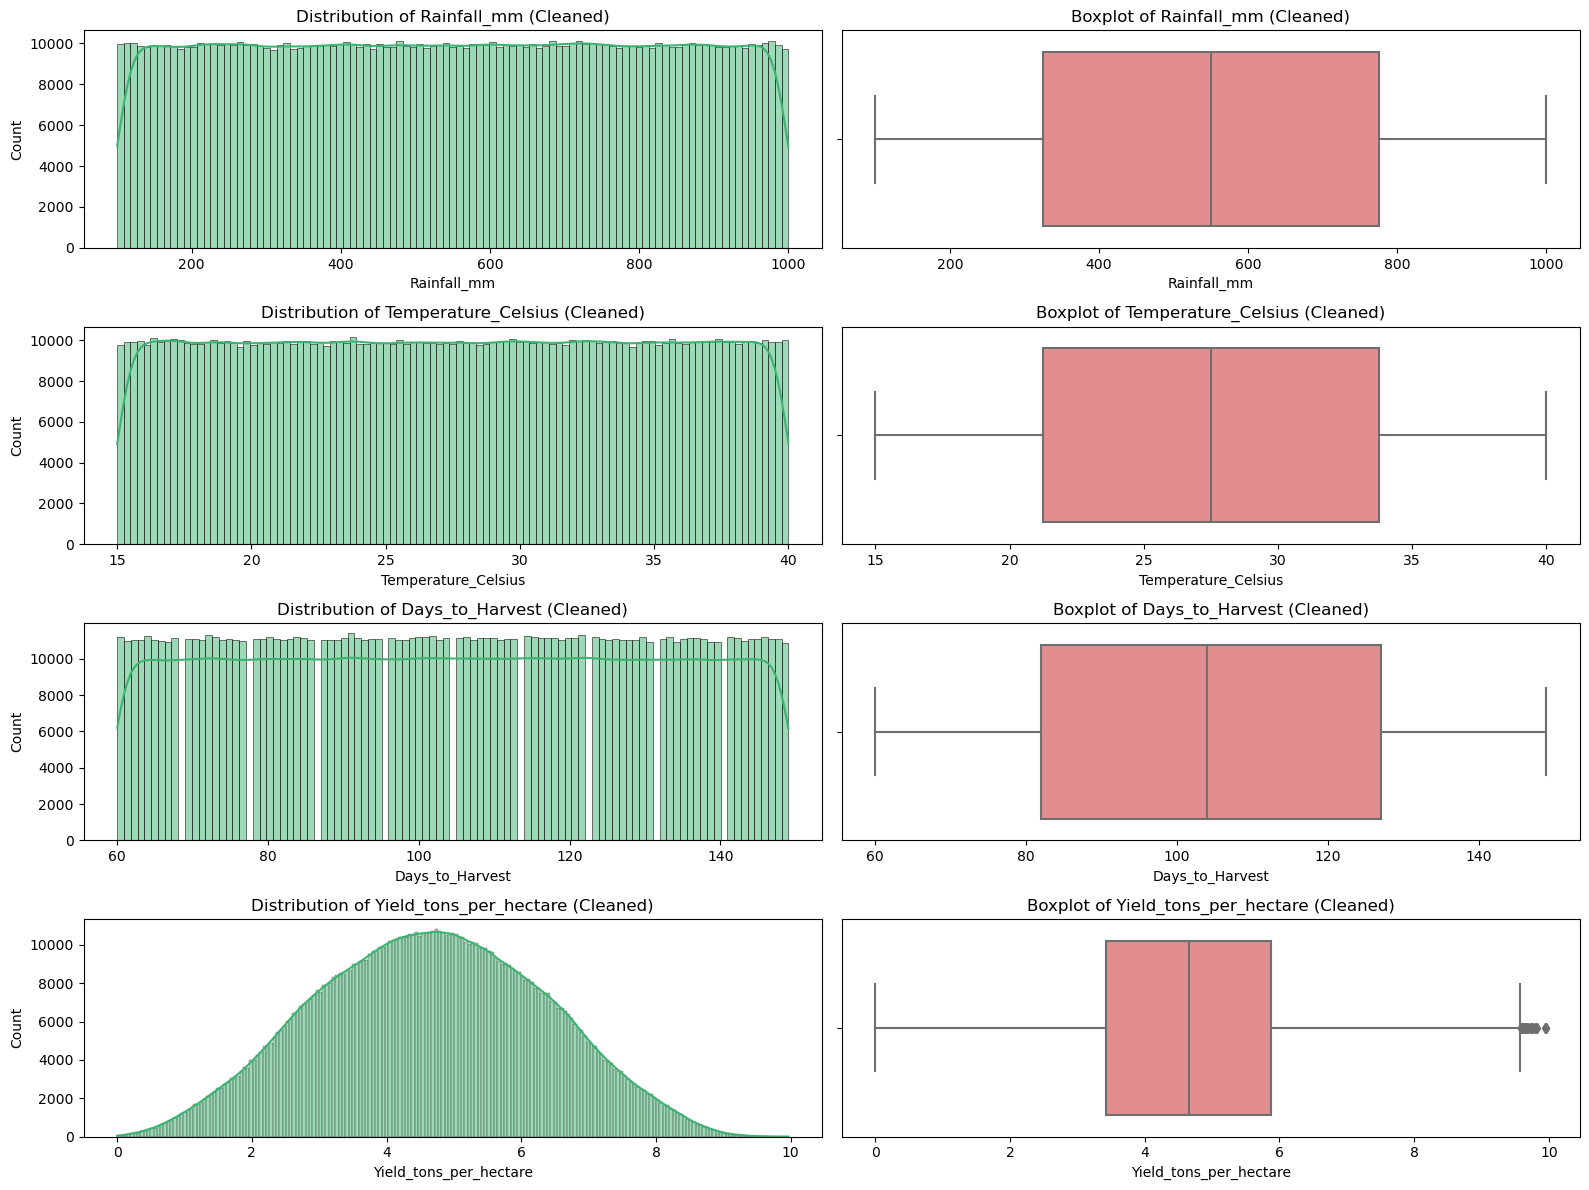

In [54]:
# Define numerical columns again
numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']

# Set up visual comparison
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 2, 2*i+1)
    sns.histplot(df_cleaned[col], kde=True, color='mediumseagreen')
    plt.title(f'Distribution of {col} (Cleaned)')
    
    plt.subplot(4, 2, 2*i+2)
    sns.boxplot(x=df_cleaned[col], color='lightcoral')
    plt.title(f'Boxplot of {col} (Cleaned)')

plt.tight_layout()
plt.show()


###  Updated Interpretation of Post-Cleaning Visuals

The post-cleaning visualizations confirm the effectiveness of our data quality process. Here's what we observe:

---

####  Rainfall_mm
- **Distribution** remains uniformly spread, confirming synthetic or evenly sampled rainfall scenarios.
- **Boxplot** shows no outliers, with consistent interquartile range — no changes from before, and that's expected.

---

####  Temperature_Celsius
- **Uniform distribution** is preserved, with values still bounded between 15°C and 40°C.
- **Boxplot** shows even spread and no outliers, same as before.
-  **No cleaning required** for this column — it was already consistent.

---

####  Days_to_Harvest
- **Histogram** continues to show a flat, uniform distribution from 60 to 149 days.
- **Boxplot** remains centered around the median, with no outliers — same as pre-cleaning.
-  Stable feature — no transformation needed.

---

####  Yield_tons_per_hectare (Target Variable)
-  **Major improvement**:
  - **Negative and zero yields are gone** — the distribution now starts from just above 0.
  - **Boxplot** no longer shows extreme lower-end outliers, confirming cleanup.
  - Right-skewed outliers remain but are expected due to natural variability.
-  Ready for modeling, with potential for scaling or transformation later.

---

### Comparison with Pre-Cleaning Visuals:
| Feature                 | Before Cleaning                | After Cleaning                         |
|------------------------|--------------------------------|----------------------------------------|
| `Yield_tons_per_hectare` | Had negative values, left skew | Clean, normal curve with right tail    |
| `Rainfall`, `Temp`, `Days_to_Harvest` | Uniform, no outliers         | Same — no change needed                |
| Outliers                | Yield had invalid outliers     | Only realistic, high-end yield outliers remain |

---

These results validate that our dataset is now structurally sound, realistic, and ready for exploratory analysis and modeling in the next phase.


<a id="final-check"></a>
## 8. Final Checks and Save Cleaned Dataset

As a final step, we validate the cleaned dataset one last time by:

- Rechecking the shape and structure
- Confirming no missing or invalid entries
- Saving a versioned copy of the cleaned dataset for downstream use (EDA, modeling, etc.)

We save the file in both `.csv` and `.pkl` (pickle) formats for flexibility in large-scale processing.


In [61]:
# Final dataset inspection
print("Final dataset shape:", df_cleaned.shape)
print("\nMissing values:\n", df_cleaned.isnull().sum())
print("\nData types:\n", df_cleaned.dtypes)

Final dataset shape: (999769, 10)

Missing values:
 Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

Data types:
 Region                     object
Soil_Type                  object
Crop                       object
Rainfall_mm               float64
Temperature_Celsius       float64
Fertilizer_Used              bool
Irrigation_Used              bool
Weather_Condition          object
Days_to_Harvest             int64
Yield_tons_per_hectare    float64
dtype: object


In [63]:
# Export as CSV
df_cleaned.to_csv("cleaned_agriculture_yield.csv", index=False)

# Optionally export as pickle (for faster I/O)
df_cleaned.to_pickle("cleaned_agriculture_yield.pkl")

print(" Cleaned dataset exported successfully!")


 Cleaned dataset exported successfully!


<a id="next-steps"></a>
## 9. Reflections & Next Steps

###  Reflections:

The data wrangling phase confirmed that the dataset is:
- Large-scale (1M+ records) and diverse across environmental and operational factors
- Clean in structure, with no missing values or formatting inconsistencies
- Mostly synthetic or evenly distributed, especially in variables like rainfall and temperature
- Realistic in its output (`Yield_tons_per_hectare`), after correcting for negative or invalid entries

We also established a reproducible cleaning pipeline that:
- Identifies and removes structural issues
- Standardizes formatting for better downstream compatibility
- Prepares the dataset for advanced analytics and machine learning

---

###  Next Steps:

We will now move into **Notebook 2: Preprocessing & Exploratory Data Analysis**, where the objectives are:
1. Perform label encoding and transformation of categorical features
2. Analyze feature relationships with the target (yield)
3. Visualize trends and interactions across crop types, regions, soil profiles, and weather
4. Detect multicollinearity or feature redundancy (e.g., via correlation heatmap)
5. Engineer initial insights for modeling, such as binning or interaction features

This step will help shape the direction of our modeling strategy and identify which features are most impactful for predicting agricultural crop yield.
